<a href="https://colab.research.google.com/github/yxmauw/GA_Capstone/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="http://imgur.com/1ZcRyrc.png" width="70" height="70" align="left" style="margin: 20px"> 
 # Capstone: Glaucoma detection using Fundoscopy images

In [ ]:
import tensorflow as tf
print(tf.__version__) #2.8.2

2.8.2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [2]:
# upload files to working directory each runtime
!git clone https://github.com/yxmauw/GA_Capstone.git # has to be public repository

Cloning into 'GA_Capstone'...
remote: Enumerating objects: 824, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 824 (delta 94), reused 120 (delta 67), pack-reused 660
Receiving objects: 100% (824/824), 212.81 MiB | 21.94 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Checking out files: 100% (656/656), done.


In [4]:
all_labels = pd.read_csv('./GA_Capstone/glaucoma_labels.csv') # this works which is weird
all_labels.head(3)

Filename  ExpCDR Eye Set  Glaucoma
0  001.jpg  0.7097  OD   A         0
1  002.jpg  0.6953  OS   A         0
2  003.jpg  0.9629  OS   A         0

In [5]:
# explore counts
all_labels['Glaucoma'].value_counts()
# 482 negative, 168 positive for glaucoma (contains both train, validation images)
# unbalanced data
# total 650 images

0    482
1    168
Name: Glaucoma, dtype: int64

In [6]:
import fnmatch
import os

# image files count
train_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Negative'), '*.jpg'))
train_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive'), '*.jpg'))
test_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Negative'), '*.jpg'))
test_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Positive'), '*.jpg'))
total_image_count = train_g_negative_count + train_g_positive_count + \
                    test_g_negative_count + test_g_positive_count
# print count
print('---Train images---')
print('Glaucoma Negative:', train_g_negative_count)
print('Glaucoma Positive:', train_g_positive_count)
print()
print('---Validation iamges---')
print('Glaucoma Negative:', test_g_negative_count)
print('Glaucoma Positive:', test_g_positive_count)
print()
print('---Total image count---')
print(total_image_count)

---Train images---
Glaucoma Negative: 386
Glaucoma Positive: 134

---Validation iamges---
Glaucoma Negative: 96
Glaucoma Positive: 34

---Total image count---
650


## Explore sample image

In [7]:
# load example image
from PIL import Image 
im = Image.open('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size)

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape) # channel last

JPEG
RGB
(3072, 2048)
[[1 3 0]
 [1 3 0]
 [1 3 0]
 ...
 [1 3 0]
 [1 3 0]
 [1 3 0]]
(2048, 3072, 3)


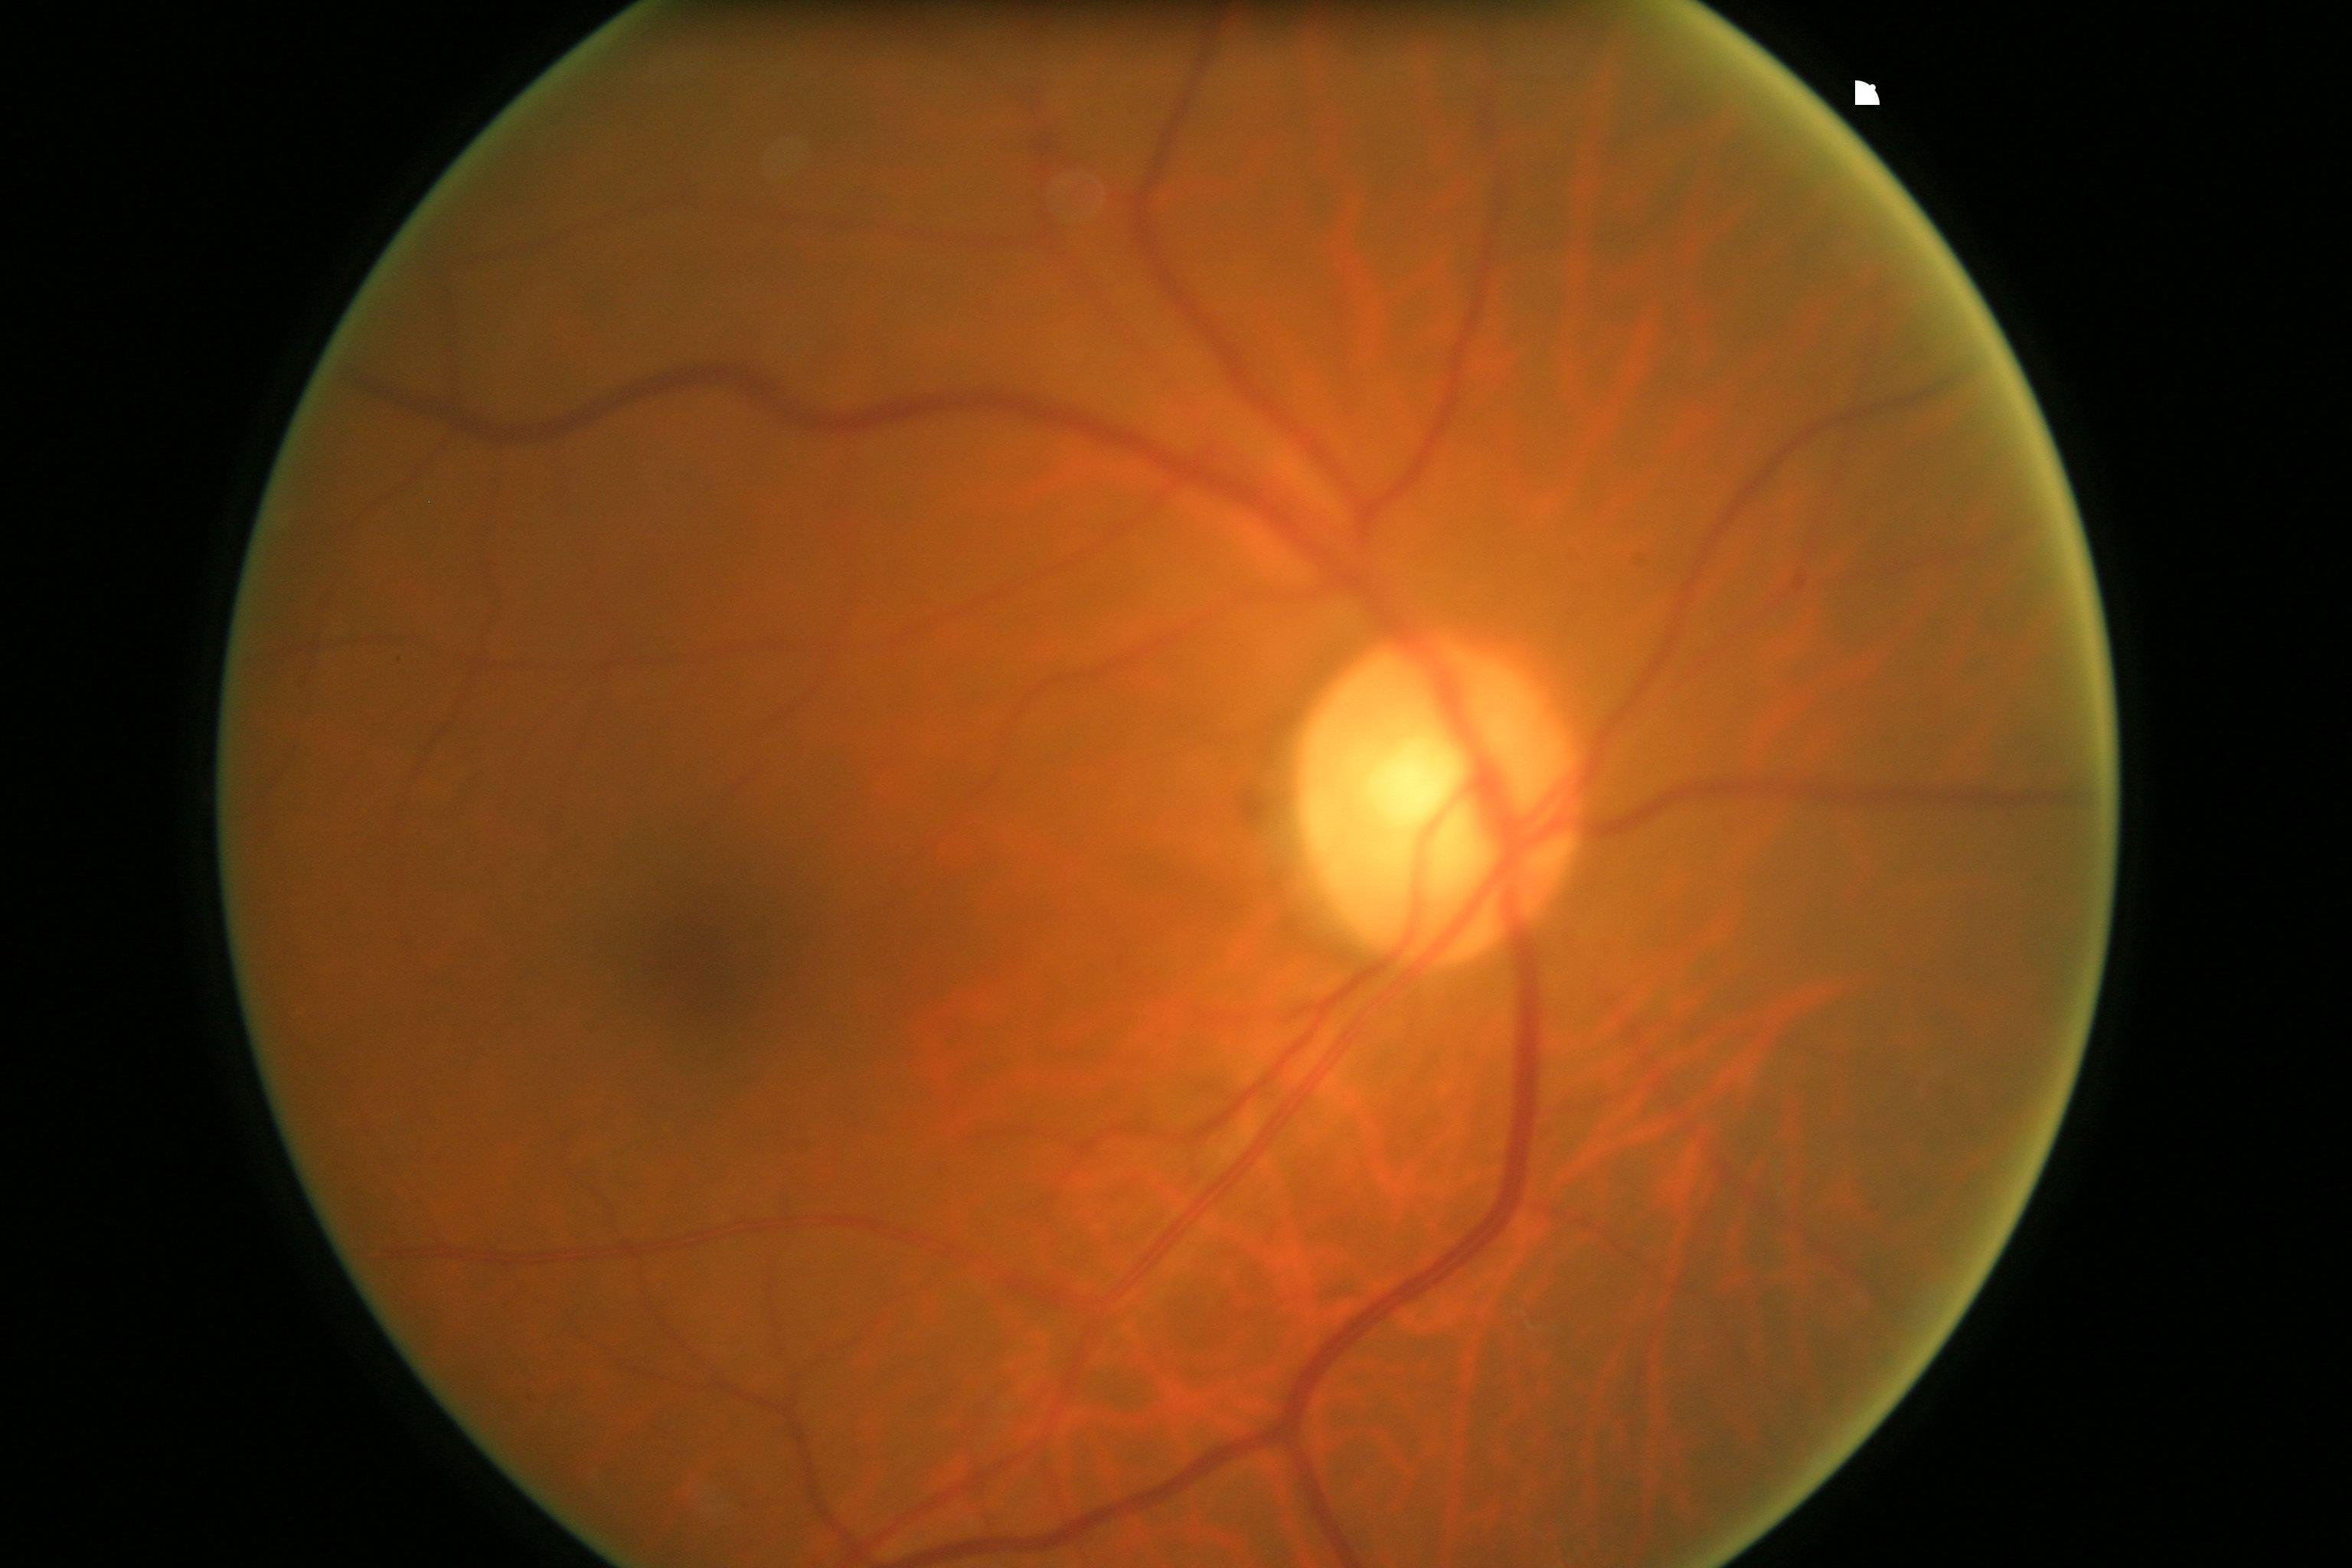

In [8]:
#Import library
from IPython import display
display.Image(filename='./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', width=220, height=150)

In [9]:
# Using one image as example
# calculate image pixel mean, min, max

mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Mean: 63.332
Min: 0.000, Max: 255.000


## Resize and rescale demonstration, visualisation
Later inbuilt into CNN pipeline

In [15]:
# global centering similar to minmaxscaler but for images
# using tf.keras.layers.Resizing and tf.keras.layers.Rescaling

from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([   
    layers.Resizing(150,220) , 
    layers.Rescaling(1./255) # desired height, width in model pipeline
])

result = resize_and_rescale(pixels)
print(result.shape) # new shape, channels # will be configured to be symmetrical in pipeline

(150, 220, 3)


Verify that the pixels are in the [0, 1] range:

In [16]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


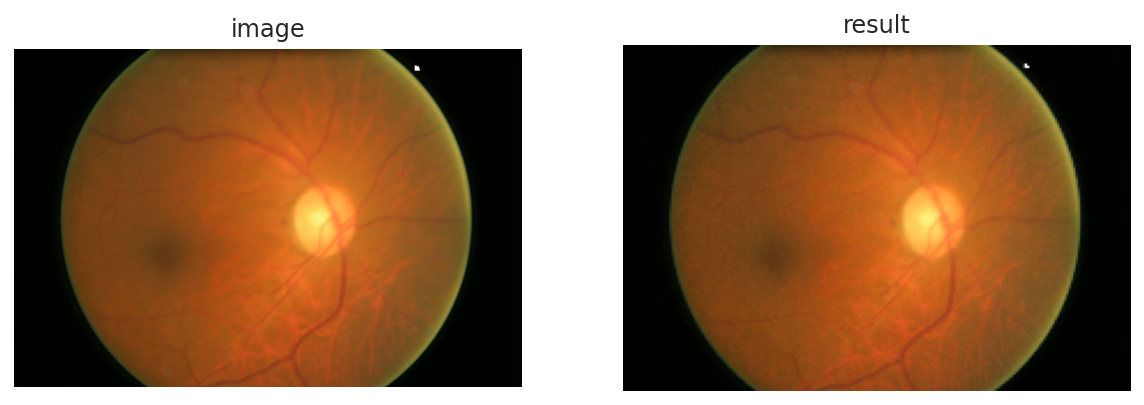

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still have good distinction of optic disc

## Construct Train and Validation datasets

In [ ]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (160, 160) # very important to get this right, will determine model success
batch_size = 32

train_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Train/',
    image_size=image_size,
    labels='inferred',
    label_mode='binary', # categorical_crossentropy
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Validation/',
    image_size=image_size,
    labels='inferred',
    label_mode='binary', # categorical_crossentropy
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

Found 520 files belonging to 2 classes.
Found 130 files belonging to 2 classes.


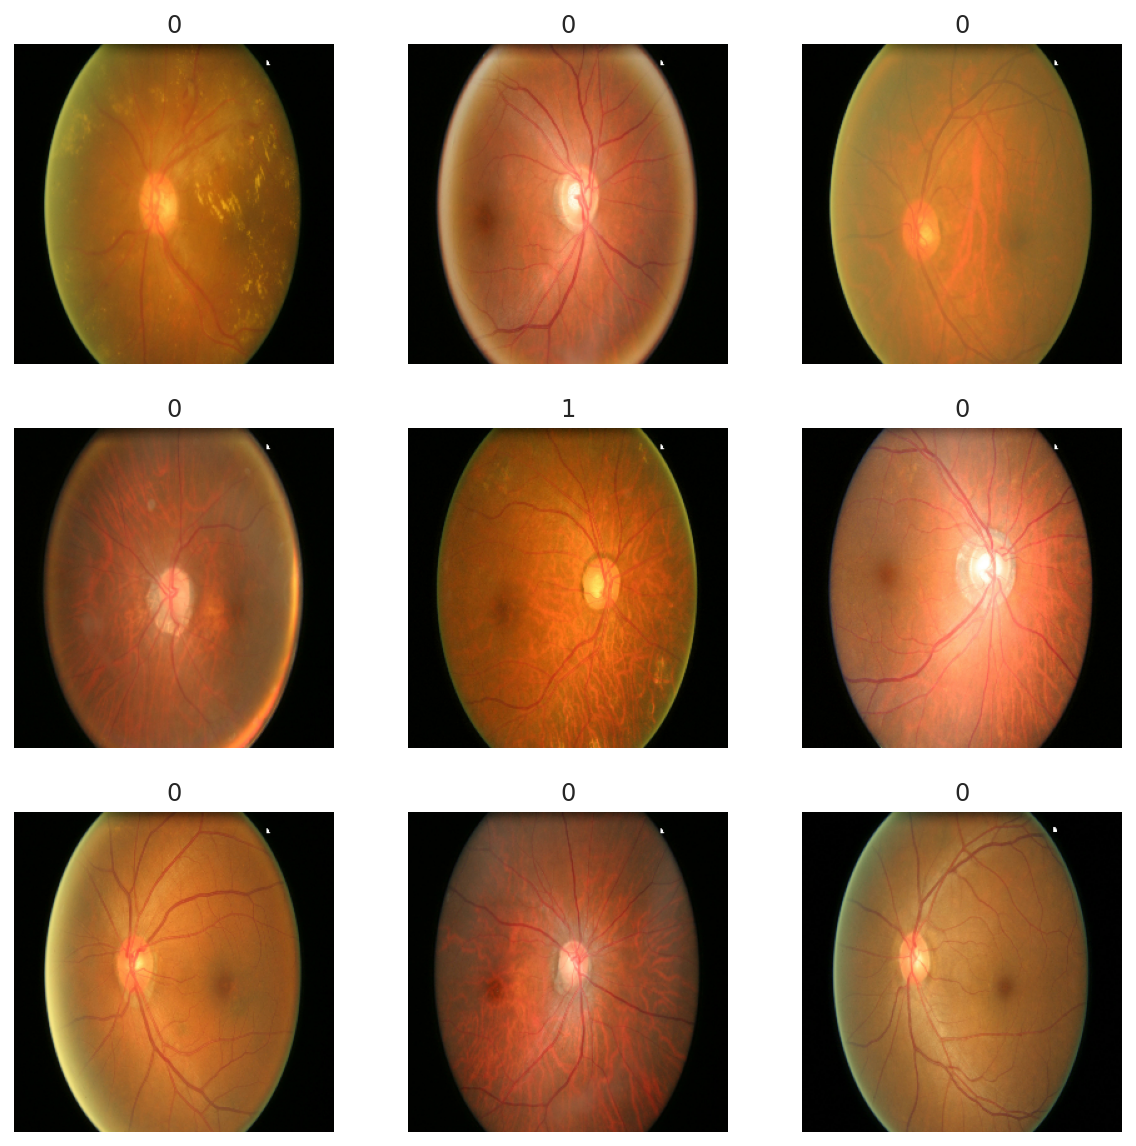

In [ ]:
# preview of how images are labelled
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # 256 x 256 size 
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Image data augmentation

__References:__
1. [Keras.io](https://keras.io/examples/vision/image_classification_from_scratch/)
1. [Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal_and_vertical", seed=42), 
      layers.RandomRotation(0.2, seed=42),
      layers.RandomContrast(0.1, seed=42),
      layers.RandomCrop(height=150, width=150, seed=1)
    ])

Visualize what augmented images look like, applying `data_augmentation` repeatedly to the first image in the train dataset

In [ ]:
# preview of how images are augmented
def augmented_ds_imgs():
  plt.figure(figsize=(8, 8))
  for images, _ in train_ds.take(1): 
    for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8")) # output standard 255 x 255
      plt.axis("off")

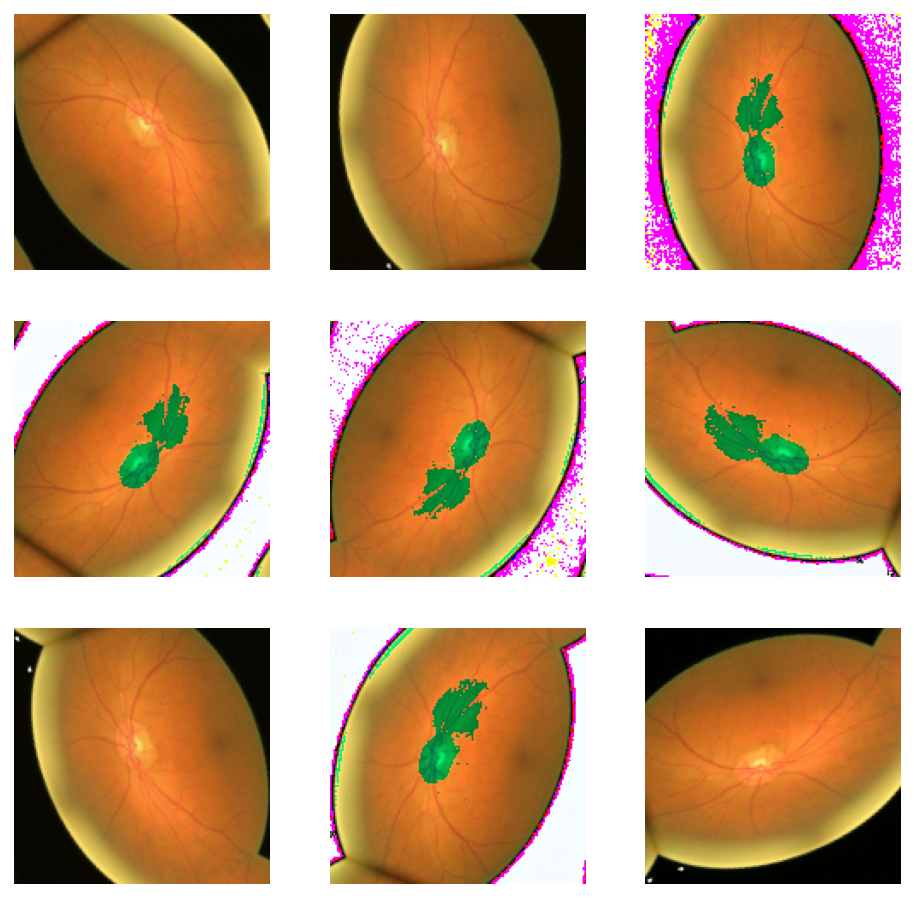

In [ ]:
augmented_ds_imgs()

#### Get Contours of image
[Reference](https://pythonexamples.org/python-opencv-cv2-find-contours-in-image/)

In [ ]:
# Import the library OpenCV
import cv2
from google.colab.patches import cv2_imshow # to stabilise cv2.imshow() function

def retina_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=30
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)
  
  # if needed, to save image
  # cv2.imwrite("contours.jpg", img_contours)

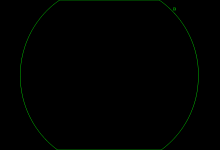

In [ ]:
retina_contour()

In [ ]:
def disc_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=155
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)
  
  # if needed, to save image
  # cv2.imwrite("contours.jpg", img_contours)

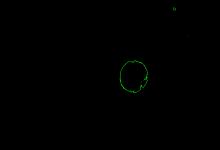

In [ ]:
disc_contour()

### Using WaterShed Algorithm to segment out retina from black background

__References:__
1. [OpenCV WaterShed](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)
2. [GeeksforGeeks](https://www.geeksforgeeks.org/removing-black-background-and-make-transparent-using-python-opencv/)

In [ ]:
def mask():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cv2_imshow(cv2.resize(thresh, (220, 150), interpolation=cv2.INTER_AREA))
  return thresh

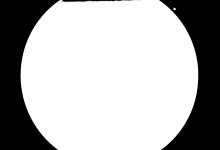

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
mask()
# black region shows background
# white region shows foreground

In [ ]:
def remove_bg():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, alpha = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  
  b, g, r = cv2.split(img) # Using cv2.split() to split channels
  
  rgba = [b, g, r, alpha] # Making list of Red, Green, Blue channels and alpha

  new_img = cv2.merge(rgba, 4)

  cv2_imshow(cv2.resize(new_img, (220, 150), interpolation=cv2.INTER_AREA))
  # if needed, save image
  cv2.imwrite("./GA_Capstone/EDA/no_bg.png", new_img) # jpg does not support alpha channel, only png or tiff format
  return new_img

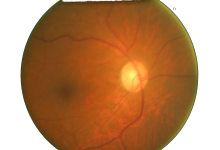

array([[0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       ...,
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0]], dtype=uint8)

In [ ]:
remove_bg()[0] # this image has 4 channels

In [ ]:
# try augmentation again
# on removed background image
image2 = cv2.imread('./GA_Capstone/EDA/no_bg.png', cv2.IMREAD_UNCHANGED)
print(image2.shape) # 4 channels
pixels2 = np.asarray(image2) # show numpy array format

print(pixels2[0])

(2048, 3072, 4)
[[0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]
 ...
 [0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]]


In [ ]:
def augmented_imgs():
  plt.figure(figsize=(8, 8))
  img = tf.io.read_file("./GA_Capstone/EDA/no_bg.png")
  # convert to tensor
  tensor = tf.io.decode_image(img, channels=4, dtype=tf.dtypes.float32)
  # resize tensor to 255 x 255
  tensor = tf.image.resize(tensor, [255, 255]) # tensor.shape # (255, 255, 4)
  # add another dimension at the front to get NHWC shape
  input_tensor = tf.expand_dims(tensor, axis=0) #input_tensor.shape (1, 255, 255, 4)
  for i in range(9):
    augmented_image = data_augmentation(input_tensor)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("float32")) # to be same as tf.dataset object type
    # float32 tensors
    plt.axis("off")

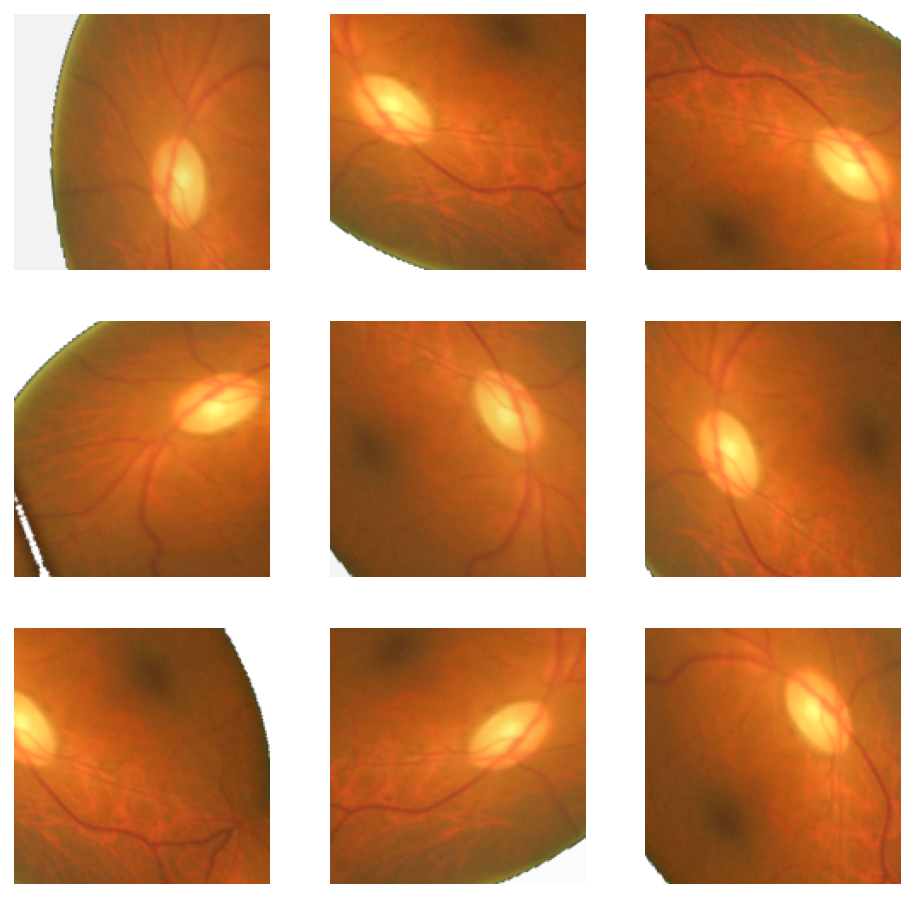

In [ ]:
augmented_imgs()

Comparing augmentation on before and after removing black background from images:
* it appears that by removing the black background, images become more distorted by augmentation. This might not be a good thing for my use case since proportion of optic disc is important for diagnosis of glaucoma. 
* Then again, with the distortion, there may be an exaggeration of proportions, which could help machine learning differentiate better between classes.
* However, I will attempt with baseline images for model with basic data augmentation and batch normalization in the model pipeline first. If there is time, will convert all images without background, and teach the model with the new images.

# UNet structure
<img src="https://miro.medium.com/max/1050/1*1Q3ODFV_t2WVXvm_09ExjA.png" width="400" height="250"> 

__Reference:__
* [UNet architecture](https://blog.paperspace.com/unet-architecture-image-segmentation/)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Dropout
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [ ]:
# Keras implementation for Unet
def u_net(image_size, n_classes):
  inputs = keras.Input(shape = image_size + (3,))
  x = layers.Rescaling(1./255)(inputs)

  # Downsample
  c1 = layers.Conv2D(16, 3, activation = 'relu', kernel_initializer= 'he_normal', padding = 'same')(x)
  c1 = layers.Dropout(0.2)(c1)
  c1 = layers.Conv2D(16, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
  p1 = layers.MaxPooling2D((2,2))(c1)

  c2 = layers.Conv2D(32, 3, activation = 'relu', kernel_initializer= 'he_normal', padding = 'same')(p1)
  c2 = layers.Dropout(0.2)(c2)
  c2 = layers.Conv2D(32, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
  p2 = layers.MaxPooling2D((2,2))(c2)

  c3 = layers.Conv2D(64, 3, activation = 'relu', kernel_initializer= 'he_normal', padding = 'same')(p2)
  c3 = layers.Dropout(0.2)(c3)
  c3 = layers.Conv2D(64, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
  p3 = layers.MaxPooling2D((2,2))(c3)

  c4 = layers.Conv2D(128, 3, activation = 'relu', kernel_initializer= 'he_normal', padding = 'same')(p3)
  c4 = layers.Dropout(0.2)(c4)
  c4 = layers.Conv2D(128, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4) # (16, 16, 128)
  p4 = layers.MaxPooling2D((2,2))(c4)

  c5 = layers.Conv2D(256, 3, activation = 'relu', kernel_initializer= 'he_normal', padding = 'same')(p4)
  c5 = layers.Dropout(0.2)(c5)
  c5 = layers.Conv2D(256, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5) # (8,8,256)

  # Upsample
  t6 = layers.Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', padding = 'same')(c5) # (16, 16, 128) 
  t6 = layers.concatenate([t6, c4]) # (16, 16, 256)
  c6 = layers.Conv2D(128, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(t6)
  c6 = layers.Dropout(0.2)(c6)
  c6 = layers.Conv2D(128, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6) # (16, 16, 128)
  
  t7 = layers.Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', padding = 'same')(c6) # (32, 32, 64) 
  t7 = layers.concatenate([t7, c3]) # (16, 16, 256)
  c7 = layers.Conv2D(64, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(t7)
  c7 = layers.Dropout(0.2)(c7)
  c7 = layers.Conv2D(64, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7) # (32, 32, 64)

  t8 = layers.Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', padding = 'same')(c7) # (32, 32, 64) 
  t8 = layers.concatenate([t8, c2]) # (16, 16, 256)
  c8 = layers.Conv2D(32, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(t8)
  c8 = layers.Dropout(0.2)(c8)
  c8 = layers.Conv2D(32, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8) # (32, 32, 64)

  t9 = layers.Conv2DTranspose(16, 2, strides = (2,2), activation = 'relu', padding = 'same')(c8) # (32, 32, 64) 
  t9 = layers.concatenate([t9, c1]) # (16, 16, 256)
  c9 = layers.Conv2D(16, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(t9)
  c9 = layers.Dropout(0.2)(c9)
  c9 = layers.Conv2D(16, 3, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9) # (32, 32, 64)

  outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
  
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
image_size = (256,256)
model = u_net(image_size = image_size, n_classes = 2)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 256, 256, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_86 (Conv2D)             (None, 256, 256, 16  448         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("saved_epoch_{epoch}.h5", save_best_only=True)
]

model.compile(optimizer="rmsprop", 
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
%%time

model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, verbose=1)

Epoch 1/15


InvalidArgumentError: ignored

# ResNet

# DenseNet